In [1]:
#see how quistkid transpile a cphase in ionq supported gates

from qiskit import QuantumCircuit, QuantumRegister,ClassicalRegister, transpile
import numpy as np
import qiskit.quantum_info as qi

#cphase gate
qreg_q = QuantumRegister(2, 'q')
cph = QuantumCircuit(qreg_q)

phase = np.pi
cph.cp(phase,0,1)

#transpile into new basis
print(cph)
trans_qc = transpile(cph, backend = None, basis_gates = ['rx', 'ry', 'rz', 'rxx'])

print(trans_qc)
print(qi.Operator(trans_qc))

            
q_0: ─■─────
      │P(π) 
q_1: ─■─────
            
global phase: 7π/4
     ┌─────────┐┌─────────┐┌───────────┐┌──────────┐            ┌───────────┐»
q_0: ┤ Rz(π/2) ├┤ Ry(π/2) ├┤0          ├┤ Rx(-π/2) ├────────────┤0          ├»
     └─────────┘└─────────┘│  Rxx(π/2) │├──────────┤┌──────────┐│  Rxx(π/2) │»
q_1: ──────────────────────┤1          ├┤ Rx(-π/2) ├┤ Rz(-π/2) ├┤1          ├»
                           └───────────┘└──────────┘└──────────┘└───────────┘»
«     ┌──────────┐┌──────────┐
«q_0: ┤ Rx(-π/2) ├┤ Ry(-π/2) ├
«     ├──────────┤├─────────┬┘
«q_1: ┤ Rx(-π/2) ├┤ Rz(π/2) ├─
«     └──────────┘└─────────┘ 
Operator([[ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
          [ 0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j],
          [ 0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))


In [2]:
%load_ext autoreload

# general imports
import numpy as np
import math
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline

# AWS imports: Import Braket SDK modules
from braket.circuits import Circuit, Gate, Instruction, circuit, Observable
from braket.devices import LocalSimulator
from braket.aws import AwsDevice
from braket.device_schema.device_action_properties import DeviceActionType
import numpy as np

from utils import Plotter, DeviceUtils, BraketTaskScanner

In [3]:
@circuit.subroutine(register=True)
def cphase_ionq(control, target, phase):

    circ = Circuit()

    #recreate Qiskit compilation
    circ.rz(control, phase/2).ry(control, np.pi/2)
    
    circ.xx(control, target, np.pi/2)

    circ.rx(control, -np.pi/2)
    circ.rx(target, -np.pi/2).rz(target, -phase/2)

    circ.xx(control, target, np.pi/2)

    circ.rx(control, -np.pi/2).ry(control, -np.pi/2)
    circ.rx(target, -np.pi/2).rz(target,phase/2)
    
    return circ

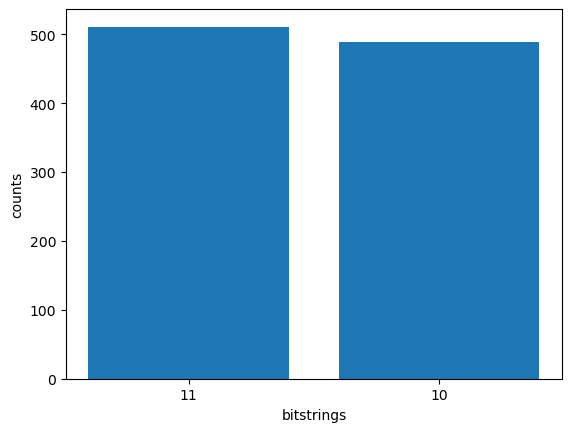

T  : |0|   1    |   2    |   3    |    4    |    5    |   6    |    7    |    8    |
                                                                                    
q0 : -X-------------------XX(1.57)-Rx(-1.57)-Rz(-1.57)-XX(1.57)-Rx(-1.57)-Rz(1.57)--
                          |                            |                            
q1 : -H-Rz(1.57)-Ry(1.57)-XX(1.57)-Rx(-1.57)-----------XX(1.57)-Rx(-1.57)-Ry(-1.57)-

T  : |0|   1    |   2    |   3    |    4    |    5    |   6    |    7    |    8    |

Additional result types: StateVector
Final EXACT state vector:
 [ 0. +0.j   0. +0.j   0.5+0.5j -0.5-0.5j]
Final Braket state vector:
 [ 0.        +0.00000000e+00j  0.        +0.00000000e+00j
  0.70710678+0.00000000e+00j -0.70710678+8.65956056e-17j]
T  : |0|     1     |
                    
q0 : -X-PHASE(3.14)-
        |           
q1 : -H-C-----------

T  : |0|     1     |

Additional result types: StateVector


In [4]:
#testin DIY phase shift

#entangling the control bit i should see the phase difference
# in the two ouput states
circ = Circuit()
circ.x(0).h(1).cphase_ionq(1,0,np.pi)
device = LocalSimulator(backend = "braket_sv")

res = device.run(circ, shots = 1000).result()
Plotter.plot_binary_results(res)

circ.state_vector()
print(circ)
res = device.run(circ, shots = 0).result()
print("Final EXACT state vector:\n", res.values[0])

#print(circ)

braket_circ = Circuit()
braket_circ.x(0).h(1).cphaseshift(1,0,np.pi).state_vector()
res = device.run(braket_circ, shots = 0).result()
print("Final Braket state vector:\n", res.values[0])

print(braket_circ)

In [5]:
#non recursive QFT implementation kindly borrowed by braket examples and adapted for IONQ

@circuit.subroutine(register=True)
def qft_ionq(qubits):    
    """
    Construct a circuit object corresponding to the Quantum Fourier Transform (QFT)
    algorithm, applied to the argument qubits.  Does not use recursion to generate the QFT.
    
    Args:
        qubits (int): The list of qubits on which to apply the QFT
    """
    qftcirc = Circuit()
    
    # get number of qubits
    num_qubits = len(qubits)
    
    for k in range(num_qubits):
        # First add a Hadamard gate
        qftcirc.h(qubits[k])
    
        # Then apply the controlled rotations, with weights (angles) defined by the distance to the control qubit.
        # Start on the qubit after qubit k, and iterate until the end.  When num_qubits==1, this loop does not run.
        for j in range(1,num_qubits - k):
            angle = 2*math.pi/(2**(j+1))
            qftcirc.cphase_ionq(qubits[k+j],qubits[k], angle)
            
    # Then add SWAP gates to reverse the order of the qubits:
    for i in range(math.floor(num_qubits/2)):
        qftcirc.swap(qubits[i], qubits[-i-1])
        
    return qftcirc



@circuit.subroutine(register=True)
def inverse_qft_ionq(qubits):
    """
    Construct a circuit object corresponding to the inverse Quantum Fourier Transform (QFT)
    algorithm, applied to the argument qubits.  Does not use recursion to generate the circuit.
    
    Args:
        qubits (int): The list of qubits on which to apply the inverse QFT
    """
    # instantiate circuit object
    qftcirc = Circuit()
    
    # get number of qubits
    num_qubits = len(qubits)
    
    # First add SWAP gates to reverse the order of the qubits:
    for i in range(math.floor(num_qubits/2)):
        qftcirc.swap(qubits[i], qubits[-i-1])
        
    # Start on the last qubit and work to the first.
    for k in reversed(range(num_qubits)):
    
        # Apply the controlled rotations, with weights (angles) defined by the distance to the control qubit.
        # These angles are the negative of the angle used in the QFT.
        # Start on the last qubit and iterate until the qubit after k.  
        # When num_qubits==1, this loop does not run.
        for j in reversed(range(1, num_qubits - k)):
            angle = -2*math.pi/(2**(j+1))
            qftcirc.cphase_ionq(qubits[k+j],qubits[k], angle)
            
        # Then add a Hadamard gate
        qftcirc.h(qubits[k])
    
    return qftcirc


# apply id or sigmax to obtain a definite integer as input
# (in binary representation)
@circuit.subroutine(register=True)
def integer_input(qubits, x):
    # instantiate circuit object
    circ = Circuit()
    
    # get number of qubits
    num_qubits = len(qubits)

    #must be able to represent input
    assert x < 2**num_qubits
    bitstring = format(x, "0"+ str(num_qubits) +"b")

    #print(bitstring)

    #todo: need to reverse iteration(?)
    for i in range(num_qubits):
        if bitstring[i] == "1" :
            circ.x(qubits[i])


    return circ

#get special state preimage of a defined integer for qft
@circuit.subroutine(register=True)
def transformed_input(qubits, x = 0):

    # get number of qubits
    num_qubits = len(qubits)

    circ = Circuit()

    circ.h(qubits)
    for ii in range(num_qubits - 1):
        circ.rz(ii+1, math.pi/(2**ii))

    return circ




In [6]:
#ionq_qft_circuit

x = 0
qbits = 4
print(qbits)

circ = transformed_input(range(qbits)).qft_ionq( range(qbits))

4


Counter({'1110': 10000})


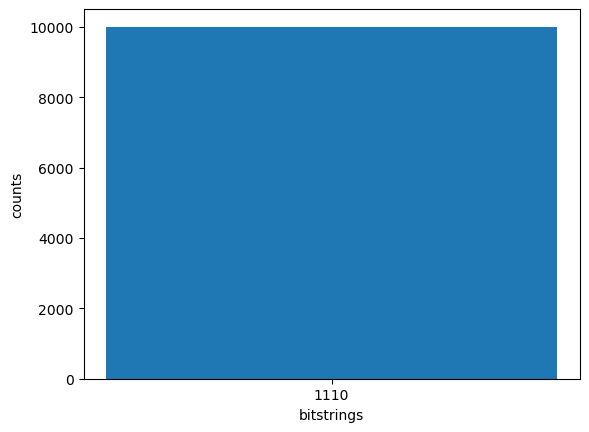

In [7]:
#test ionq_qft on Local simulator

device = LocalSimulator()

result = device.run(circ, shots = 10000).result()

Plotter.plot_binary_results(result, debug=True)

In [8]:
#ionq qft on ionq

device = DeviceUtils.get_device("ionq")

qft_task = device.run(circ, shots = 1000)
print(qft_task._arn)

arn:aws:braket:us-east-1:058017682654:quantum-task/82c535bb-2740-4819-a285-5d46fe421621


In [26]:
#might as well try it also on rigetti device

device = DeviceUtils.get_device("rigetti")

qft_task = device.run(circ, shots = 100)
print(qft_task._arn)

#oof rigetti does not support xx gate

ValidationException: An error occurred (ValidationException) when calling the CreateQuantumTask operation: [line 12] uses a gate: xx which is not supported by the device or defined via a defcal

In [3]:
ionq_qft_id = "arn:aws:braket:us-east-1:058017682654:quantum-task/b026b6a8-94ce-4a16-94f2-3e626c7087b4"
ionq_2nd_qft = "arn:aws:braket:us-east-1:058017682654:quantum-task/f96b9e98-aa64-4919-b494-ddf04dbbcc53"
ionq4 =  "arn:aws:braket:us-east-1:058017682654:quantum-task/82c535bb-2740-4819-a285-5d46fe421621"
rigetti_ionq_qft_id = None

scanner = BraketTaskScanner(task_arn= ionq4)

print(scanner.cost_extimate())
print(scanner.get_status())

10.3000000000
COMPLETED


Counter({'1010': 179, '1110': 171, '0110': 137, '1111': 79, '0010': 64, '0100': 55, '1000': 52, '1101': 46, '0011': 42, '1011': 42, '0111': 36, '1100': 27, '0000': 21, '0001': 20, '1001': 17, '0101': 12})


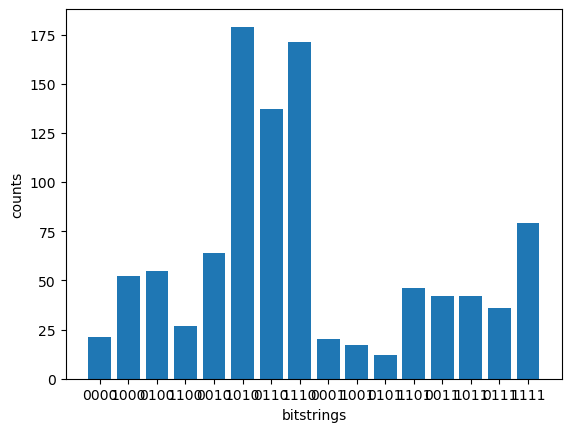

62.5 1000 1000.0 16


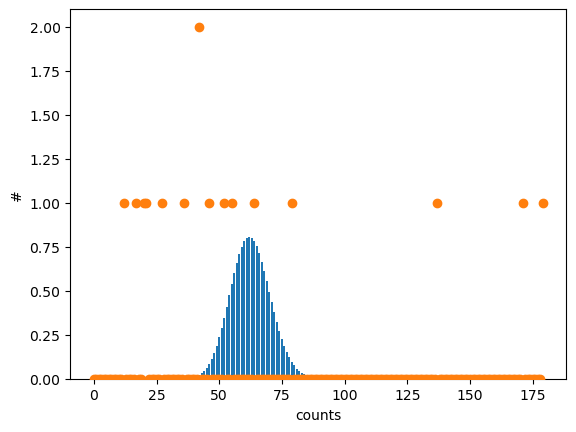

Normalized chi quared for results statistics: 45.39733333333333


False

In [6]:
#print(scanner.get_circuit())

Plotter.plot_binary_results(scanner.get_results(), debug = True)
Plotter.plot_results_statistic(scanner.get_results())

scanner.is_garbage()

In [14]:
#bigget ionq qft

x = 0
qbits = 10
print(qbits)

qft10 = transformed_input(range(qbits)).qft_ionq( range(qbits))

10


Counter({'1111111110': 10000})


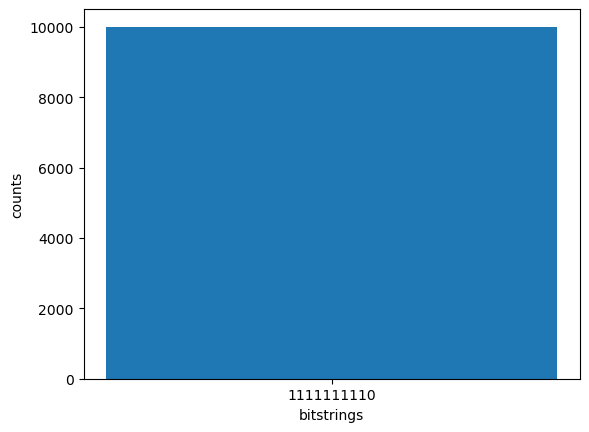

In [16]:
#test ionq_qft on Local simulator

device = LocalSimulator()

result = device.run(qft10, shots = 10000).result()

Plotter.plot_binary_results(result, debug=True)